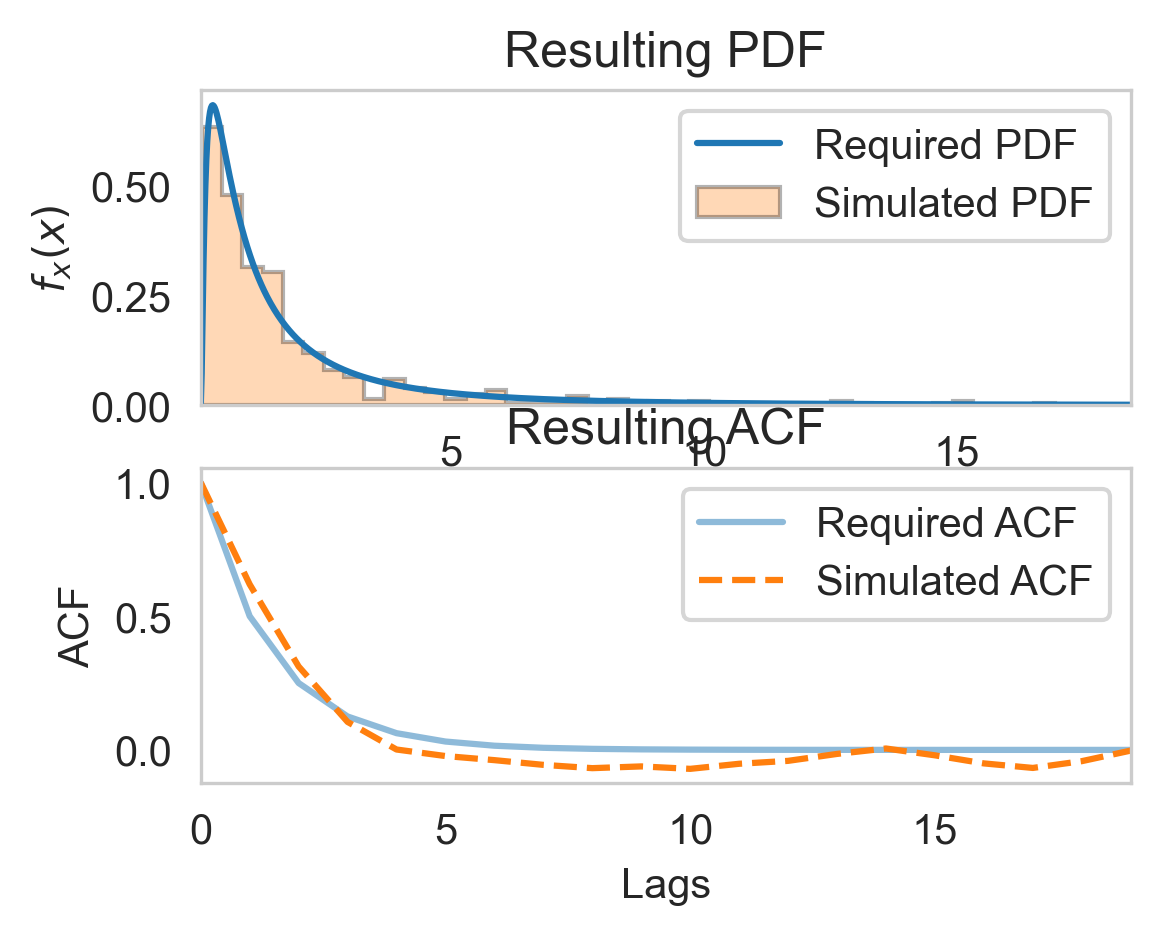

array([ 0.67423672,  0.40269076,  3.20676203,  3.20592586,  8.43752451,
       15.19401425,  1.1355924 ,  2.96381373,  3.77770583,  0.30682904,
        0.33433338,  0.53719694,  0.51838288,  0.39866956,  1.28149989,
        0.59880434,  0.44993045,  0.37812076,  0.55473284,  2.07151076,
        2.15258567,  2.44932447,  1.09326935,  0.39652092,  0.18835599,
        0.28541895,  0.81415063,  0.59384207,  0.51750374,  0.64751482,
        1.02185408,  0.99166729,  1.01620999,  0.87095393,  1.20360823,
        5.0431051 ,  2.42117336,  1.93833927,  0.86842818,  0.4287107 ,
        0.70110944,  2.49157422,  3.57413854,  0.98103239,  0.75947819,
        0.59473925,  1.11800423,  0.9878065 ,  0.88928523,  0.47653792,
        0.64423508,  0.74601157,  2.57085294,  0.95846015,  5.66637233,
        6.42940045, 15.23412336,  1.27785828,  0.45068175,  0.12603743,
        0.07804077,  0.13238119,  0.48049013,  0.2744601 ,  0.61475371,
        1.59083108,  1.19206834,  1.58057694,  1.55178074,  1.83

In [1]:
from generate_corr_sequence import gen_corr_sequence
import scipy.stats as st
import numpy as np

acf = 1 / (2 ** np.arange(20))

delays  = gen_corr_sequence(
    dist_obj=st.lognorm(s=1.2, loc=0.046, scale=1),
    L=500,
    target_acf=acf,
    debug=True,
)
delays

In [2]:
delays.size

500

In [3]:
acf_50 = 1 / (2 ** np.arange(5))  # 0.5 corr
acf_25 = 1 / (4 ** np.arange(5))
acf_12 = 1 / (8 ** np.arange(5))
acf_00 = np.zeros(5)
acf_00[0] = 1.0


In [4]:
acf_50

array([1.    , 0.5   , 0.25  , 0.125 , 0.0625])

In [5]:
acf_25

array([1.        , 0.25      , 0.0625    , 0.015625  , 0.00390625])

In [6]:
from collections import deque
import pandas as pd

scales = (
    0.1,
    0.2,
    0.4,
    0.8,
    1.6,
    3.2,
)
min_bound = 0.042
shape = 1.2


rows = deque()
for scale in scales:
    dist = st.lognorm(s=shape, loc=min_bound, scale=scale)
    mean, var = dist.stats()
    rows.append({
        r"$ S $": shape,
        "location": min_bound,
        "scale": scale,
        r"$\mu$": mean,
        r"$\sigma$": np.sqrt(var),
        "\num{95}\textsuperscript{th} percentile": dist.ppf(.95)
    })
    
df = pd.DataFrame(rows).set_index(["$ S $", "location", "scale"])
df

$\mu$   $\sigma$  \
$ S $ location scale                        
1.2   0.042    0.1    0.247443   0.368695   
               0.2    0.452887   0.737389   
               0.4    0.863773   1.474779   
               0.8    1.685547   2.949558   
               1.6    3.329093   5.899115   
               3.2    6.616186  11.798230   

                      \num{95}\textsuperscript{th} percentile  
$ S $ location scale                                           
1.2   0.042    0.1                                   0.761815  
               0.2                                   1.481630  
               0.4                                   2.921261  
               0.8                                   5.800522  
               1.6                                  11.559043  
               3.2                                  23.076087

In [7]:
print(
    df
    .to_latex(
        float_format="%0.2f"
    )
)

\begin{tabular}{lllrrr}
\toprule
 &  &  & $\mu$ & $\sigma$ & 
um{95}	extsuperscript{th} percentile \\
$ S $ & location & scale &  &  &  \\
\midrule
\multirow[t]{6}{*}{1.200000} & \multirow[t]{6}{*}{0.042000} & 0.100000 & 0.25 & 0.37 & 0.76 \\
 &  & 0.200000 & 0.45 & 0.74 & 1.48 \\
 &  & 0.400000 & 0.86 & 1.47 & 2.92 \\
 &  & 0.800000 & 1.69 & 2.95 & 5.80 \\
 &  & 1.600000 & 3.33 & 5.90 & 11.56 \\
 &  & 3.200000 & 6.62 & 11.80 & 23.08 \\
\cline{1-6} \cline{2-6}
\bottomrule
\end{tabular}



In [32]:
from typing import Tuple
import scipy.stats as stats

target_mean_var_s = (
    (2*0.050, 2*0.010),
    (2*0.100, 2*0.020),
    (2*0.200, 2*0.040),
    (2*0.400, 2*0.080),
    (2*0.800, 2*0.160),
    (2*1.600, 2*0.320),
)
loc = 0.046


def lognorm_with_params(loc: float | int, mean: float | int, var: float | int) -> Tuple[stats.rv_continuous, float, float]:
    sigma2 = np.log((var / np.square(mean - loc)) + 1)
    mu = np.log(mean - loc) - (sigma2 / 2)
    scale = np.exp(mu)
    s = np.sqrt(sigma2)
    return st.lognorm(loc=loc, scale=scale, s=s), scale, s


for (mean, var) in target_mean_var_s:
    dist, scale, s = lognorm_with_params(loc, mean, var)
    d_mean, d_var, *_ = dist.stats()
    print(f"PARAMS Scale: {scale} | S: {s}")
    print(f"MEAN Expected: {mean:0.02f}s | Actual {d_mean:0.02f}s.")
    print(f"VARIANCE Expected: {var:0.02f}s | Actual {d_var:0.02f}s.")
    print()


PARAMS Scale: 0.019262742222029956 | S: 1.4358351376115295
MEAN Expected: 0.10s | Actual 0.10s.
VARIANCE Expected: 0.02s | Actual 0.02s.

PARAMS Scale: 0.09395441436893014 | S: 0.9941256372246269
MEAN Expected: 0.20s | Actual 0.20s.
VARIANCE Expected: 0.04s | Actual 0.04s.

PARAMS Scale: 0.2765636681237385 | S: 0.7026462185427219
MEAN Expected: 0.40s | Actual 0.40s.
VARIANCE Expected: 0.08s | Actual 0.08s.

PARAMS Scale: 0.6660750170157892 | S: 0.4979760348629696
MEAN Expected: 0.80s | Actual 0.80s.
VARIANCE Expected: 0.16s | Actual 0.16s.

PARAMS Scale: 1.4602594752154132 | S: 0.35275518214689566
MEAN Expected: 1.60s | Actual 1.60s.
VARIANCE Expected: 0.32s | Actual 0.32s.

PARAMS Scale: 3.057188633662402 | S: 0.2497027915445451
MEAN Expected: 3.20s | Actual 3.20s.
VARIANCE Expected: 0.64s | Actual 0.64s.



In [43]:
def gamma_with_params(loc: float | int, mean: float | int, var: float | int) -> Tuple[stats.rv_continuous, float, float]:
    scale = var / (mean - loc)
    k = np.square(mean - loc) / var
    return st.gamma(a=k, loc=loc, scale=scale), scale, k

for (mean, var) in target_mean_var_s:
    dist, scale, k = gamma_with_params(loc, mean, var)
    d_mean, d_var, *_ = dist.stats()
    print(f"PARAMS Scale: {scale} | Shape: {k}")
    print(f"MEAN Expected: {mean:0.02f}s | Actual {d_mean:0.02f}s.")
    print(f"VARIANCE Expected: {var:0.02f}s | Actual {d_var:0.02f}s.")
    print()

PARAMS Scale: 0.19999999999999998 | Shape: 0.5000000000000001
MEAN Expected: 0.10s | Actual 0.10s.
VARIANCE Expected: 0.02s | Actual 0.02s.

PARAMS Scale: 0.19999999999999998 | Shape: 1.0000000000000002
MEAN Expected: 0.20s | Actual 0.20s.
VARIANCE Expected: 0.04s | Actual 0.04s.

PARAMS Scale: 0.19999999999999998 | Shape: 2.0000000000000004
MEAN Expected: 0.40s | Actual 0.40s.
VARIANCE Expected: 0.08s | Actual 0.08s.

PARAMS Scale: 0.19999999999999998 | Shape: 4.000000000000001
MEAN Expected: 0.80s | Actual 0.80s.
VARIANCE Expected: 0.16s | Actual 0.16s.

PARAMS Scale: 0.19999999999999998 | Shape: 8.000000000000002
MEAN Expected: 1.60s | Actual 1.60s.
VARIANCE Expected: 0.32s | Actual 0.32s.

PARAMS Scale: 0.19999999999999998 | Shape: 16.000000000000004
MEAN Expected: 3.20s | Actual 3.20s.
VARIANCE Expected: 0.64s | Actual 0.64s.



Mean 0.10 Var 0.02 ACF acf00


/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  I = quad(integration_function, integration_min, integration_max, args=(numberOfHermitePoly, dist_obj))
/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.

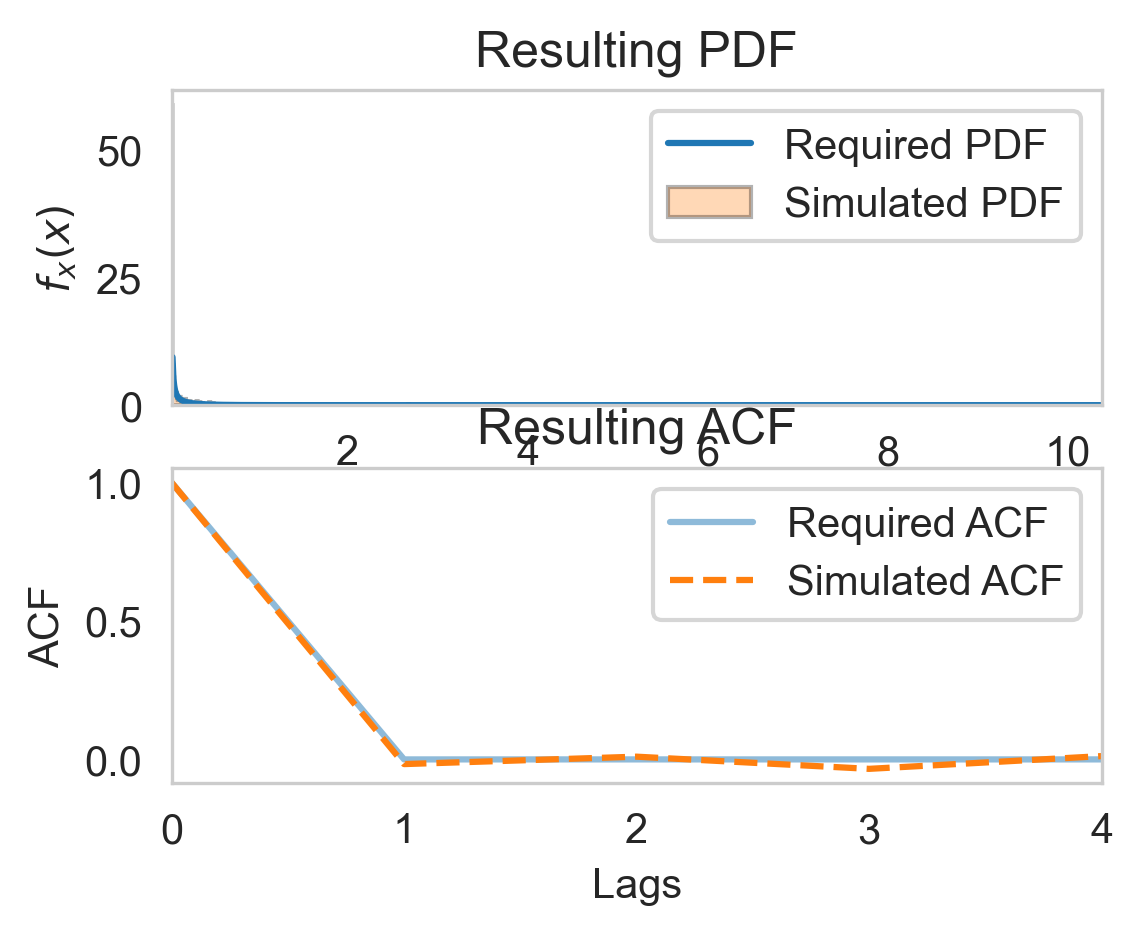

[0.04558466 0.05029482 0.04606471 0.04217603 0.32422826 0.04200032
 0.042      0.04206344 0.04210776 0.04200002 0.04315033 0.04200005
 0.05523227 0.32486179 0.13418827 0.12169916 0.05088346 0.04200002
 0.06240348 0.04228545 0.0547724  0.1150871  0.09279755 0.04221288
 0.06519971 0.04215317 0.05083611 0.04200773 0.70755813 0.04377521
 0.61482811 0.04200576 0.04345174 0.21987507 0.04288483 0.04204339
 0.46170942 0.14735522 0.13677904 0.33578378 0.04206622 0.12251473
 0.04203119 0.04200001 0.31252173 0.04573149 0.04200059 0.06966201
 0.0420233  0.06242196 0.10614745 0.04315699 0.22251394 0.07391912
 0.04687953 0.07420624 0.04484371 2.68232872 0.0420001  0.04203021
 0.04218931 0.35251446 0.21838156 0.21067917 0.06397567 0.35244401
 0.04204814 0.042      0.04223766 0.06828737 1.18798385 0.042
 0.0420057  0.04680464 0.05775311 0.04217509 0.04207098 0.04378884
 0.04202101 0.22322525 0.04202305 0.32132711 0.06744489 0.05315101
 0.04213748 0.04202634 0.04602859 0.04200466 0.04219281 0.04200007


/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  I = quad(integration_function, integration_min, integration_max, args=(numberOfHermitePoly, dist_obj))
/Users/molguin/.venvs/EdgeDroid/lib/python3.11/site-packages/generate_corr_sequence/generate_corr_sequence.py:46: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.

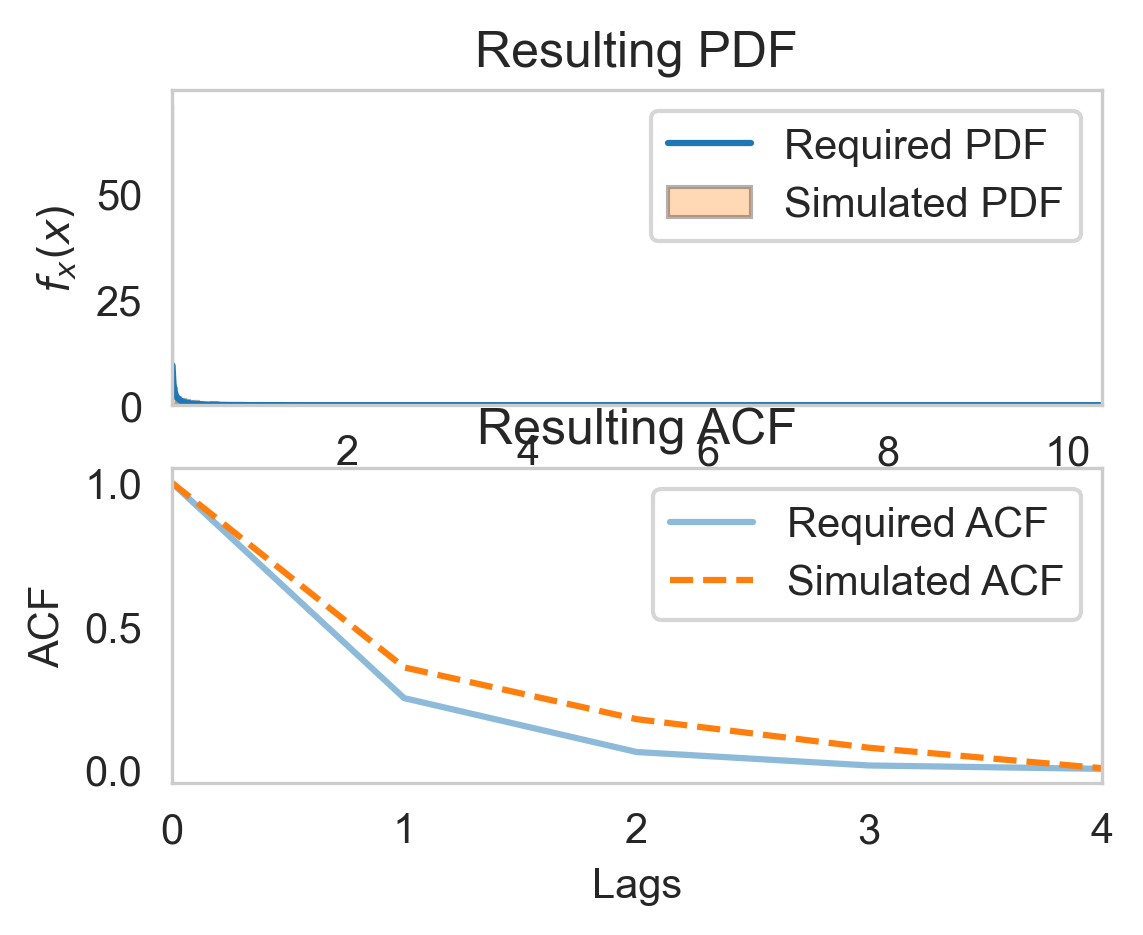

[0.05151338 0.04218886 0.04200003 0.04202916 0.04200007 0.04746342
 0.52422829 0.44453629 0.04356869 0.08694103 0.04822565 0.05846807
 0.79069433 0.46358495 0.22870367 0.042317   0.04272207 0.05471987
 0.04236203 0.29497088 0.0752239  0.07026025 0.06553207 0.04211378
 0.04200409 0.06949293 0.07453132 0.07969175 0.11882774 0.06079615
 0.04317868 0.04200148 0.04200019 0.04200297 0.042      0.06082386
 0.0420011  0.04393842 0.11716938 0.05812355 0.08471063 0.04411268
 0.04822894 0.04273706 0.05572062 0.04200169 0.042      0.07112547
 0.1259305  0.11573279 0.07928702 0.1879397  0.0705935  0.04358133
 0.04209073 0.04769855 0.0420113  0.05442718 0.04214721 0.08087876
 0.04271776 0.0588804  0.15385973 0.04746457 0.04288158 0.04277154
 0.0532244  0.042      0.06007362 0.05798351 0.49330579 0.45446892
 1.26833434 0.83413714 0.61969994 0.54594931 0.08596975 0.09300782
 0.04405921 0.04246516 0.0420016  0.04228281 0.04200025 0.04200013
 0.0544547  0.18964615 0.04265816 0.04200003 0.04200359 0.2784

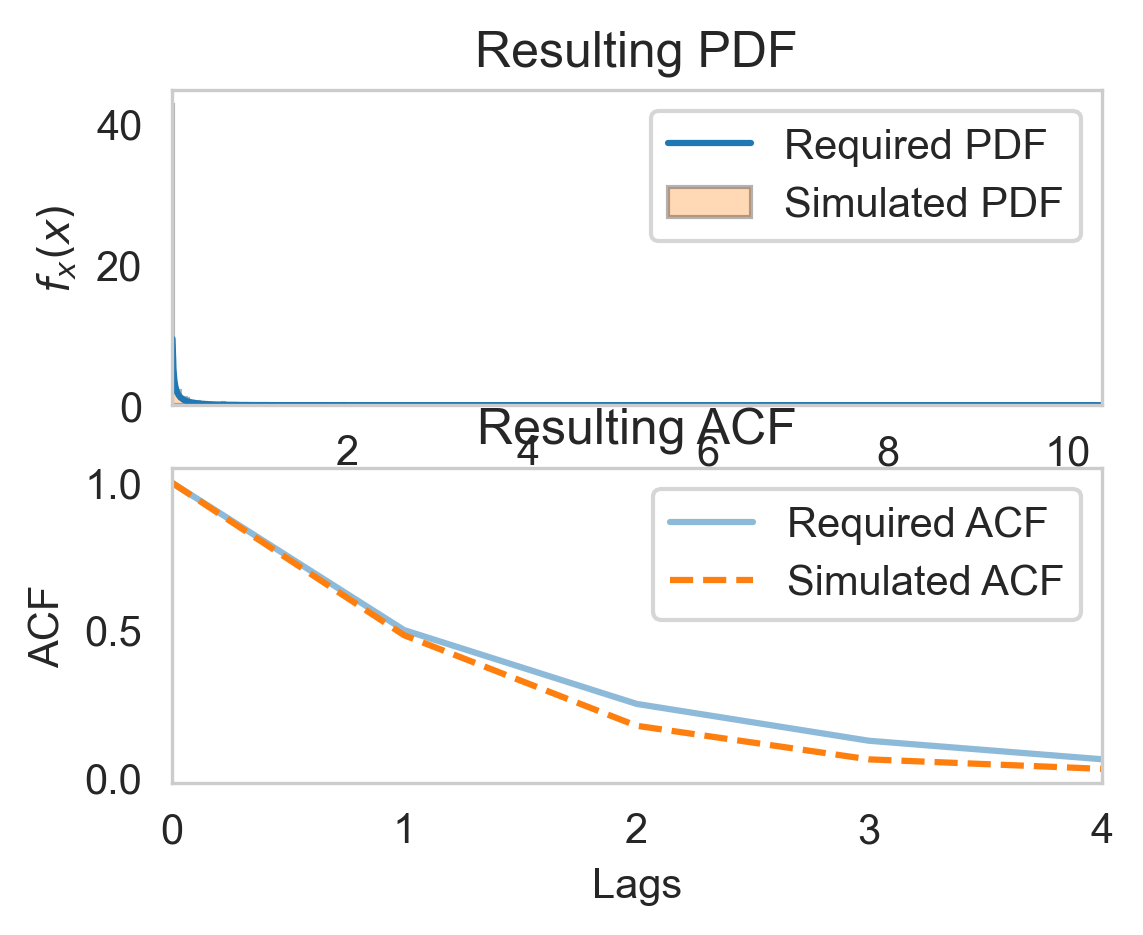

[0.05912927 0.0434185  0.16558433 0.06953995 0.04372461 0.04843935
 0.04363837 0.04200015 0.04200704 0.042      0.042      0.042
 0.05146805 0.05511259 0.04210519 0.11317115 0.04254681 0.04778102
 0.05080118 0.05306229 0.06219695 0.04203225 0.04200003 0.04454474
 0.04255798 0.04232054 0.042      0.042      0.04206557 0.04232564
 0.04206366 0.04200115 0.05433211 0.05866861 0.04373094 0.04532277
 0.04202572 0.042      0.04203446 0.04250059 0.04200173 0.04347345
 0.043347   0.04226187 0.04210993 0.05759276 0.13719387 0.08312679
 0.12067985 0.04588669 0.07876562 0.04202623 0.04200954 0.04200321
 0.0428325  0.04219666 0.07456095 0.05989603 0.04200677 0.042
 0.04200012 0.04200047 0.0433276  0.1013106  0.07932801 0.04410244
 0.04236629 0.04262982 0.08564714 0.04286344 0.04465106 0.05535897
 0.0621559  0.04267611 0.04915463 0.04382849 0.08488391 0.07680562
 0.10496381 0.07779559 0.15077247 0.10330241 0.04247133 0.04543689
 0.20356345 0.15039419 0.10287641 0.0532496  0.07052748 0.04435772
 0.04

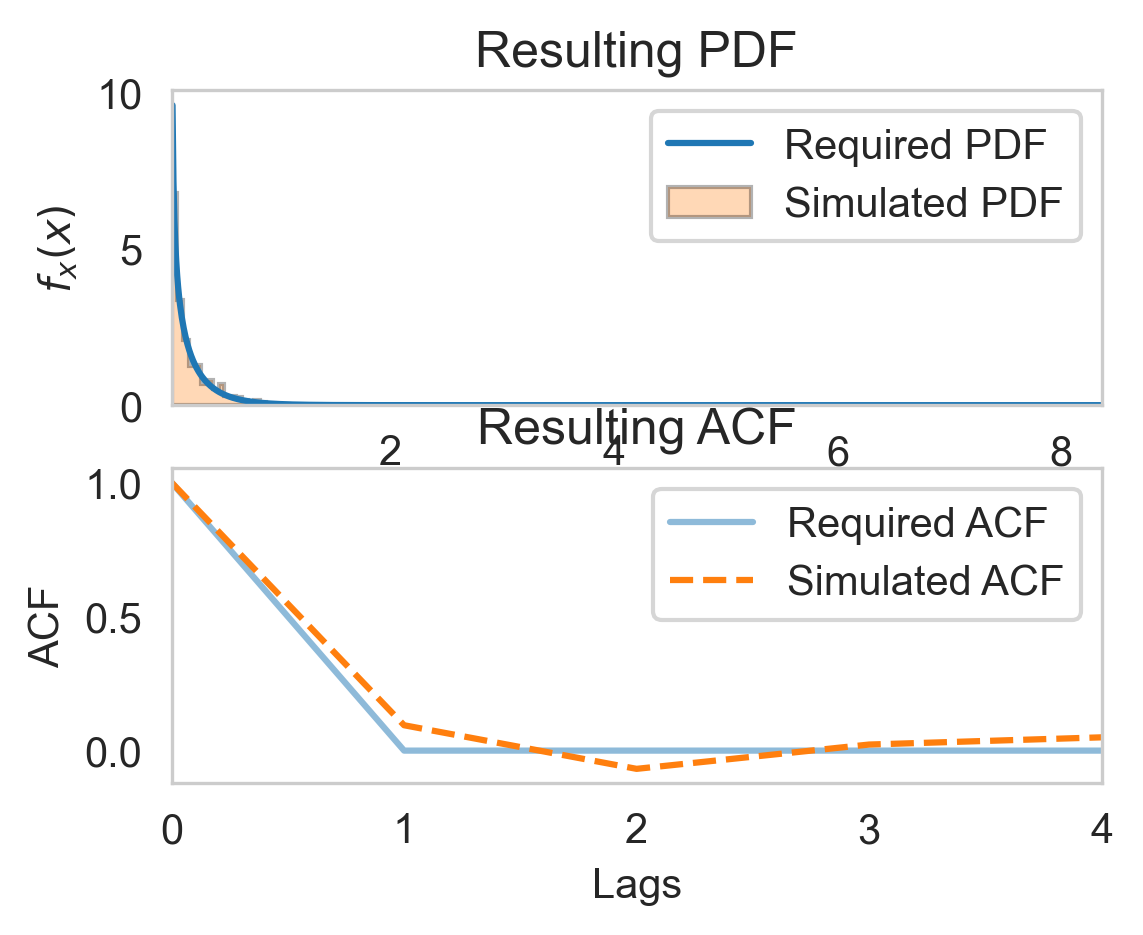

[0.19541344 0.04391192 0.38664225 0.44685718 0.37947992 0.25661941
 0.09501478 0.32703091 0.06170622 0.14732445 0.24725213 0.41944795
 0.04528811 0.39904248 0.57603956 0.36135761 0.04445491 0.15818673
 0.19575039 0.06990759 0.10732737 0.04662226 0.04417311 0.11007024
 0.25047722 0.09611252 0.25176139 0.06857103 0.61415683 0.4024637
 0.40136725 0.97660274 0.0452789  0.07015135 0.1992071  0.11599471
 0.15317749 0.16364151 0.05757655 0.04805932 0.06539256 0.11317128
 0.31126325 0.6831358  0.79848981 0.0586779  0.44862129 0.05620795
 0.0658224  0.30478447 0.18279254 0.04298791 0.270988   0.15146962
 0.17507173 0.04367579 0.05688754 0.18039745 0.04241496 0.20675005
 0.0422489  0.0582824  0.3101595  0.27565162 0.18650011 0.16507954
 0.12086285 0.12997375 0.12936433 0.44905616 0.0772527  0.06550462
 0.28591264 0.46573992 0.10261822 0.05051131 0.91574295 0.28667325
 0.04228371 0.05550495 0.07782916 0.25937443 0.07699229 0.07403788
 0.06961543 0.48305904 0.46501899 0.50562713 0.05552493 0.08400

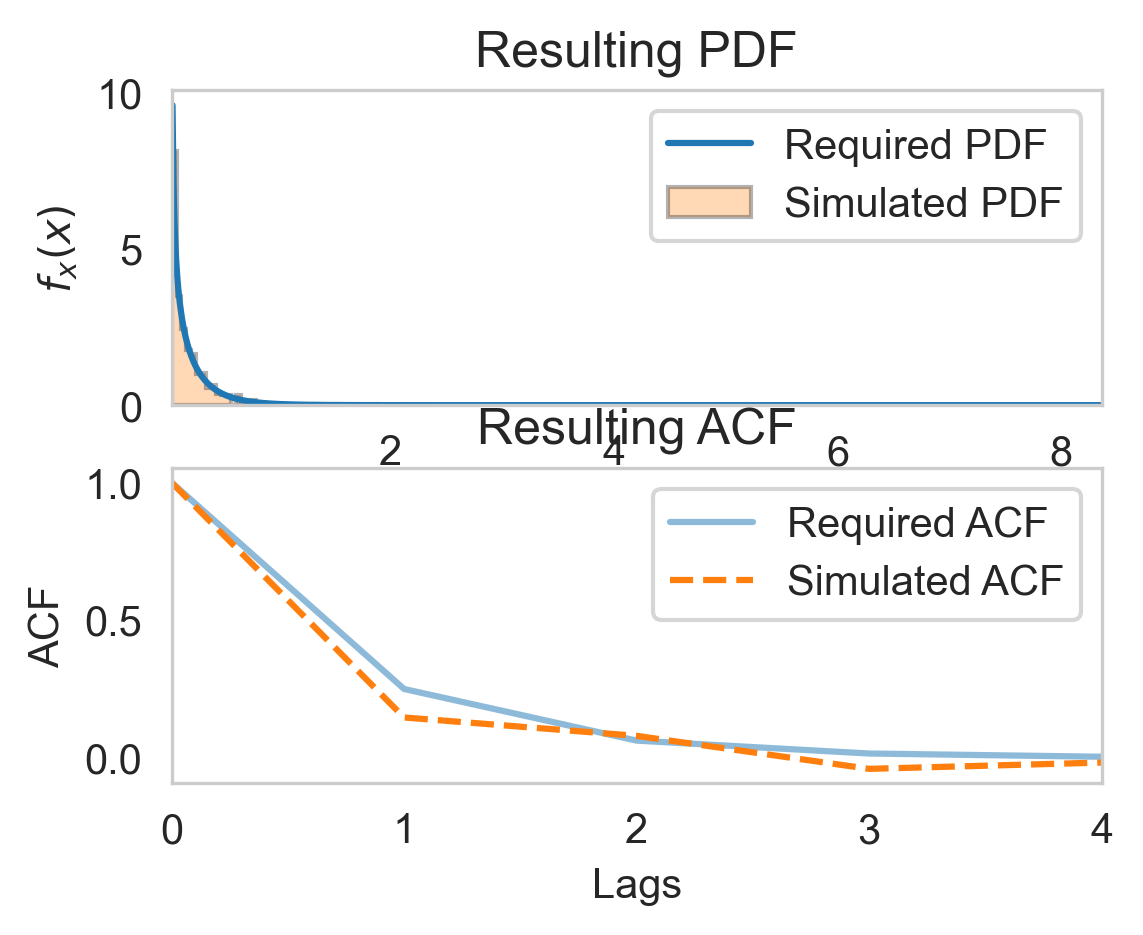

[0.08667921 0.16517987 0.05363393 0.16016313 0.2050649  0.09739536
 0.04257349 0.09110541 0.34391145 0.0517404  0.05259971 0.04597597
 0.33022245 0.11403706 0.43532063 0.07491449 0.16261606 0.39208605
 0.25566677 0.21874873 0.0863457  0.26647767 0.07895925 0.0525776
 0.07901509 0.43841765 0.34247312 0.11371508 0.191198   0.25800436
 0.06721164 0.09054102 0.0448187  0.05359713 0.05864916 0.05321299
 0.05882659 0.3582528  0.07235457 0.21937184 0.14605956 0.04252494
 0.05035515 0.05059361 0.23076629 0.75681901 0.05687954 0.14348374
 0.12585202 0.19823871 0.21583275 0.17171439 0.22476665 0.65382855
 0.1063633  0.08307814 0.55572621 0.10173754 0.34051464 0.40232375
 0.20446608 0.04747535 0.06740027 0.04260627 0.19156881 0.08808488
 0.19792122 0.07186628 0.07030026 0.07459766 0.08543481 0.09304101
 0.07843865 0.04817618 0.18026573 0.31934734 0.42097541 0.13867929
 0.41204052 0.05425473 0.38208307 0.07627653 0.27202978 0.05559648
 0.11501556 0.15217029 0.08431818 0.04316583 0.15600965 0.16199

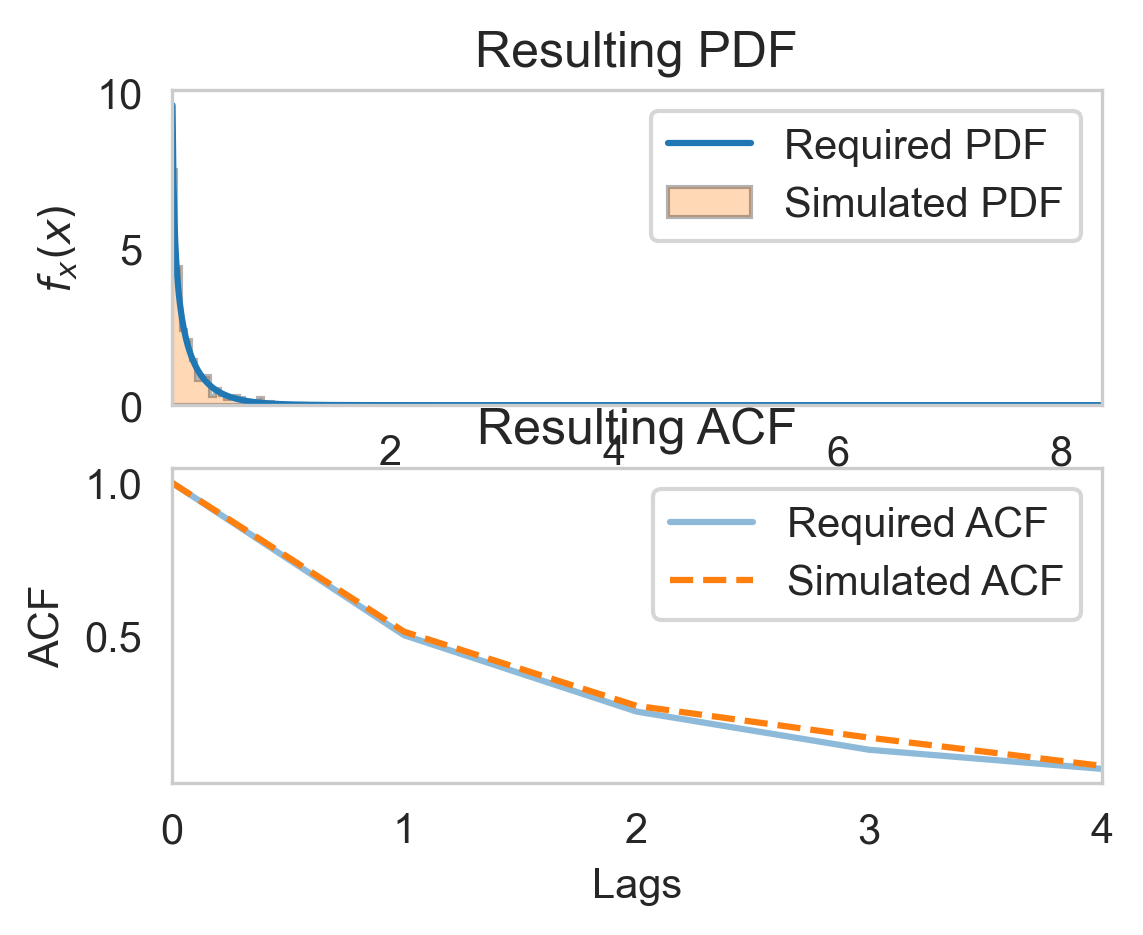

[0.10746738 0.05384279 0.05310293 0.0924455  0.04718978 0.05430784
 0.04345697 0.05044666 0.12823651 0.3464123  0.1444549  0.44698016
 0.18355154 0.04937491 0.09593859 0.13755791 0.22404644 0.07530774
 0.1634609  0.16510562 0.15250092 0.34666503 0.18134387 0.17818174
 0.36390461 0.16070572 0.59294755 0.91884077 0.68461316 0.27402382
 0.45915274 0.12737742 0.19980324 0.21318008 0.12098524 0.05710407
 0.16093331 0.07537303 0.18157086 0.17594664 0.93945846 0.82224664
 0.82045044 0.37559125 0.15708768 0.22130663 0.30569553 0.05686239
 0.04950192 0.05096436 0.05685638 0.12621963 0.08940919 0.08714487
 0.39264792 0.1401135  0.10416161 0.1240196  0.19013247 0.44489293
 0.72036517 0.42012023 0.06372848 0.10122935 0.09995298 0.10364574
 0.10688139 0.0607069  0.16538184 0.04285276 0.04410911 0.04702817
 0.04477492 0.04211949 0.09538036 0.06554954 0.07330465 0.06475786
 0.06094522 0.08825379 0.07808001 0.04356536 0.10009654 0.04970357
 0.05658768 0.06854995 0.13114755 0.30719    0.19762625 0.7048

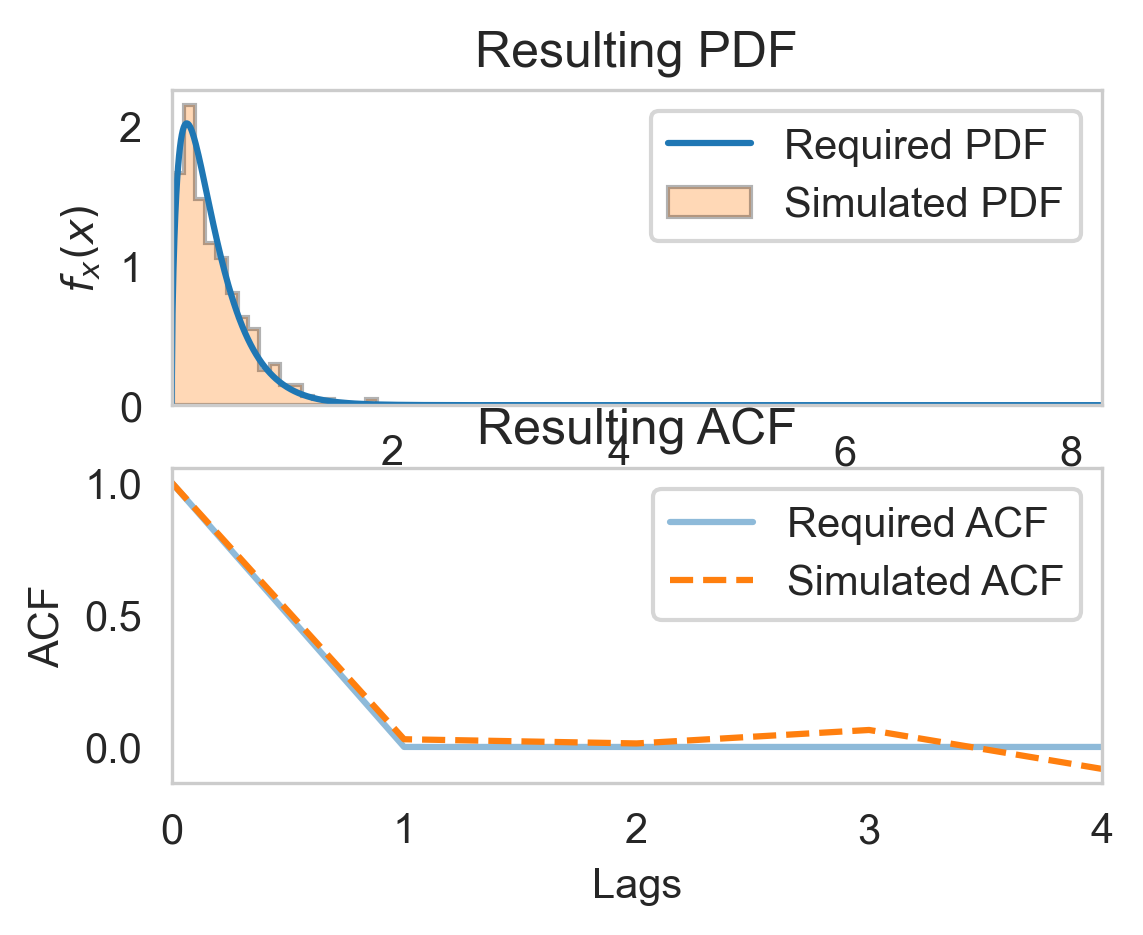

[0.47830805 0.24971395 0.77431639 0.18050327 0.05878474 0.61013791
 0.6641417  0.27704821 0.20420982 0.31474083 0.12441944 0.25055175
 0.55710023 0.09042    0.75310379 0.31295235 0.16438881 0.11125484
 0.10378665 0.93564444 0.19564004 1.05121039 0.3640307  0.83509351
 0.38973155 0.10697748 0.30783023 0.8092871  0.5333708  0.48519242
 0.76808365 0.3763356  0.07395851 0.29375056 0.06541655 0.31780068
 1.00240693 0.28179055 0.08101892 0.06107824 0.65169979 0.46174373
 0.78525129 0.31398221 0.11090787 0.75760706 1.2844878  0.35080044
 0.1763544  0.10687701 0.12717061 0.75026369 0.28680238 0.30341072
 0.20206142 0.20239814 0.16862978 0.42125355 0.12471869 1.05411843
 0.23630265 0.42647875 0.5434025  0.54840875 0.52311638 0.2536275
 0.3552318  0.26364382 0.3814878  0.71503245 0.23763576 0.3194591
 0.54580578 0.21197729 0.07553769 0.51814919 0.3821726  0.68014375
 0.56566863 0.13407983 0.18381854 0.87330941 0.24823976 0.48477134
 1.07896797 0.26873461 0.90959767 0.86963516 0.2481359  0.612246

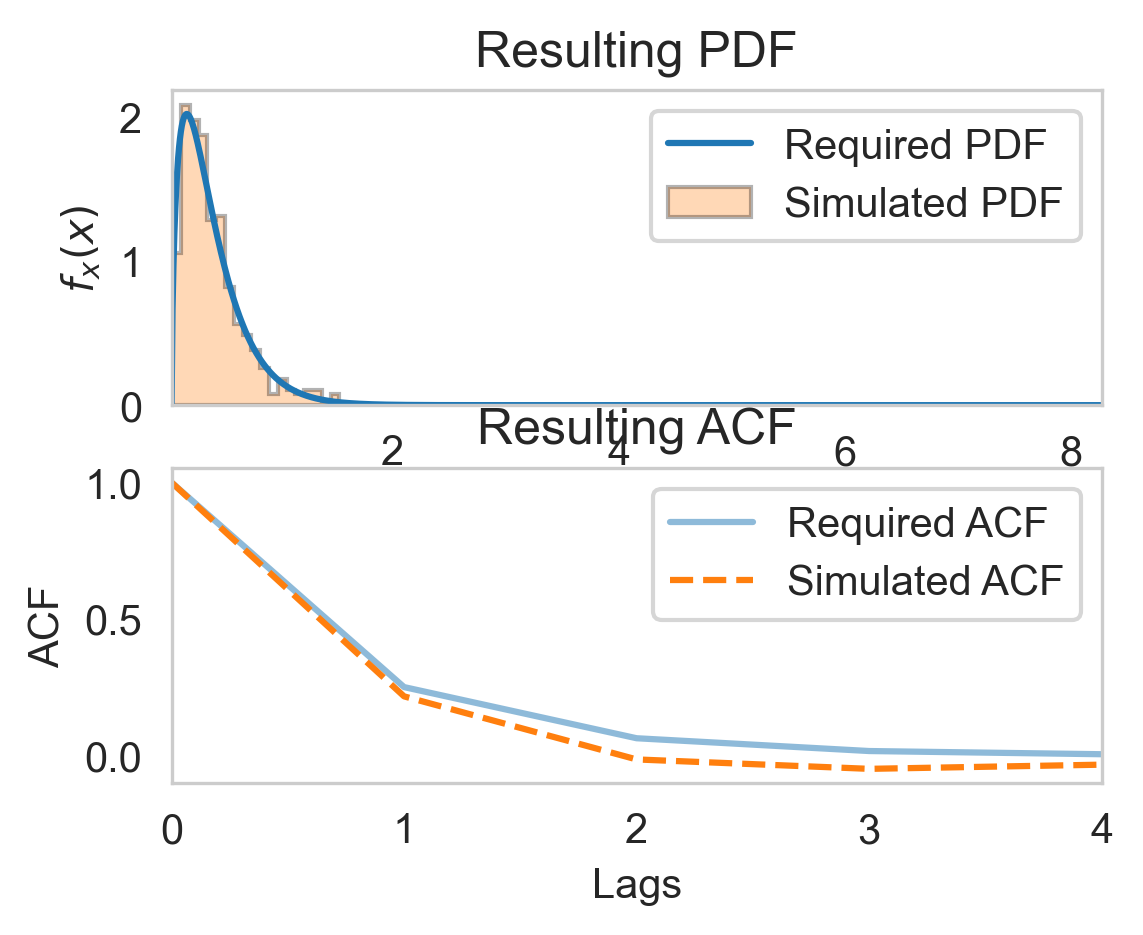

[0.66677655 0.13228005 0.15037974 0.13264137 0.13962189 0.20217789
 0.19116709 0.35337361 0.33757742 0.14990532 0.18687745 0.22631434
 0.53610979 0.35601251 0.36711911 0.56419313 0.13745062 0.45919874
 0.61675454 0.68314253 1.03167371 0.34965702 0.28765134 0.06511514
 0.14135232 0.19590351 0.06276606 0.10452532 0.414126   0.18776654
 0.18512472 0.14099087 0.27590933 0.51033501 1.03088055 0.28592552
 0.09781923 0.53810121 0.52132439 0.42083385 0.27080395 0.25706823
 0.20480002 0.16934918 0.26659283 0.23690604 0.24168534 0.13966269
 0.2173054  0.32652166 0.06628761 0.28806642 0.36855186 0.3547368
 0.67116047 0.63508979 0.20862275 0.36115743 0.38261261 0.25013348
 0.61722192 0.52437124 0.48608928 0.25774326 0.58955747 0.39345723
 0.46319329 0.43691696 1.0460258  0.8955653  0.26816547 0.20519764
 0.27365518 1.16617849 0.37511658 0.30212278 0.37422254 0.53595786
 0.57161237 0.29732113 0.32213767 0.29677748 0.31309862 0.30465968
 0.32523899 0.11142364 0.51821904 0.13415468 0.19230141 0.29833

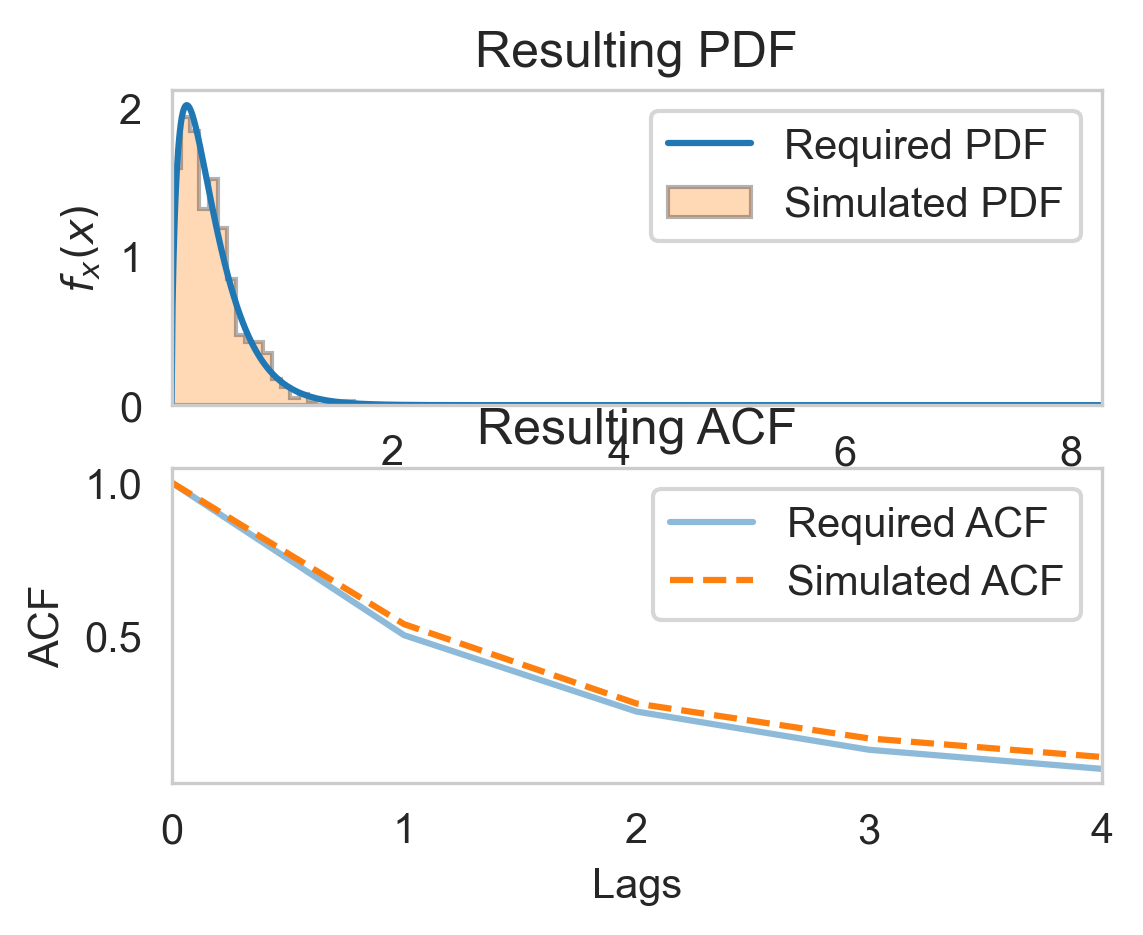

[0.5790102  0.39132197 0.2733969  0.49606202 0.48915926 0.18960187
 0.19959063 0.29087369 0.37483699 0.41140097 0.24278892 0.14712225
 0.24954058 0.78725846 0.3920923  0.28776837 0.23451069 0.6986843
 0.58662074 0.6565032  0.40134919 0.13844585 0.34932333 0.39459319
 0.22926612 0.41962163 0.36151126 0.19889963 0.08125623 0.30472695
 0.44806565 0.49445933 0.31117321 0.60343703 0.69452294 0.39317156
 0.20584825 0.75728518 0.39791496 0.85306519 0.62706492 0.44417427
 0.41823363 0.0875565  0.20845004 0.05344802 0.12412207 0.05967545
 0.07269494 0.08189124 0.10797146 0.15876766 0.15518812 0.11279571
 0.194718   0.43906748 0.24902916 0.60414063 0.50494785 0.84916322
 0.34103545 0.31092117 0.16099378 0.22055755 0.2694668  0.5261747
 0.47089058 0.41711526 0.56307858 0.41619607 0.4060229  0.38789945
 0.82698105 0.40832825 0.75933115 0.31525194 0.12323279 0.04928238
 0.06535868 0.11662777 0.63558591 0.80853538 0.55489479 0.96388064
 1.15088995 0.83830642 0.692836   0.26599174 0.12568783 0.125556

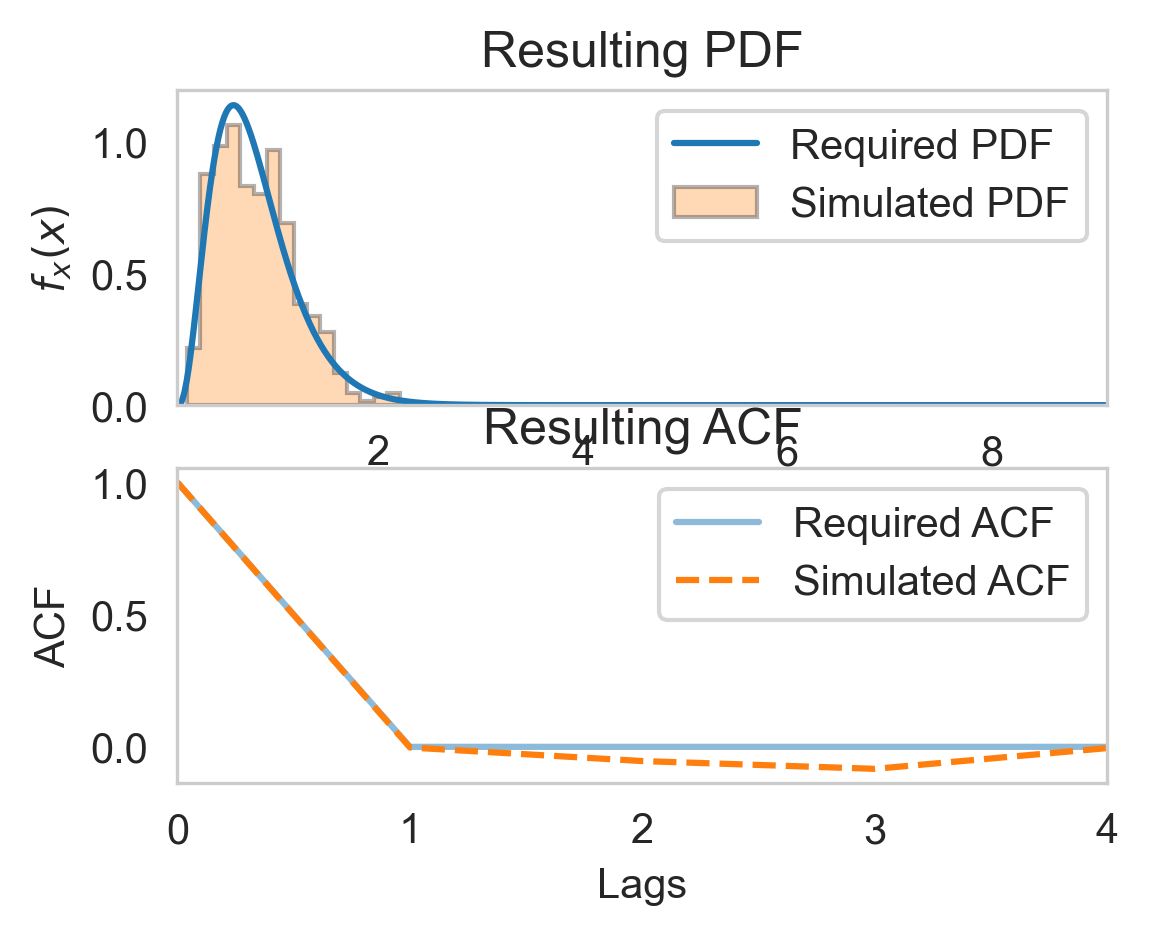

[0.74262033 1.02833505 0.41848602 1.47065563 0.98323893 0.77006396
 0.80674812 0.54721353 1.58453796 1.71833097 0.58808196 0.80287261
 0.21861382 0.31262041 0.8067307  0.36238593 0.75137421 0.39696429
 0.88899723 0.29960645 0.35007926 0.86609853 0.9265266  1.41619964
 0.87548316 0.51577545 0.67050192 0.90279912 1.68645107 0.98025816
 0.61884627 0.27384063 0.41601115 0.45003848 0.37088581 1.04011145
 0.66555515 0.64062395 1.05703699 1.0503401  1.15437897 0.79988228
 0.40264023 0.73378746 0.75641397 0.3654378  0.72513719 0.95015549
 1.06899265 1.00481691 0.90386743 0.72066004 1.18434272 1.06986223
 0.69589036 0.39846565 0.70958176 1.33811492 0.15307781 0.60251119
 0.57246169 1.35877477 0.70992499 0.6834503  0.93613552 0.45231747
 0.79029694 0.99336771 0.70962121 0.49458954 1.50283257 0.71920938
 0.99785389 1.54899186 0.24661781 1.48080595 0.47914947 0.79359176
 0.27144599 0.48583199 1.13797986 0.82427993 0.33858999 0.90117993
 0.34486786 0.97504471 0.6785897  0.94918036 0.62541022 0.2726

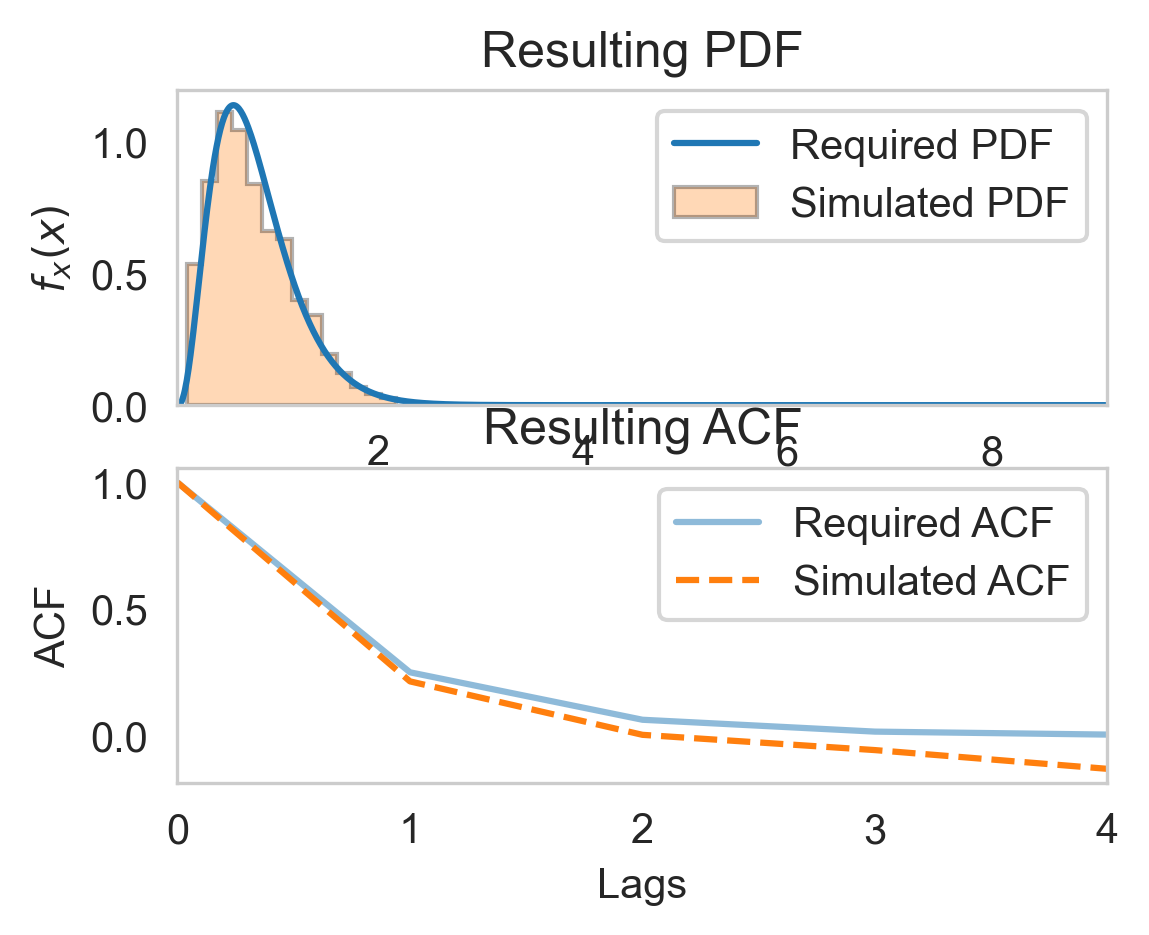

[0.7437342  0.84323923 1.05630439 1.10776927 0.38227437 0.63240292
 0.39232643 0.45530584 0.27193962 0.18826658 0.78147924 1.16640293
 0.58705886 0.57506152 0.52384301 0.43008865 0.55139226 0.97148891
 0.57776773 1.00332637 1.30458718 0.46544461 0.74549835 0.79200424
 0.76909173 0.5646531  0.64024148 0.60237056 0.61447902 1.24485838
 1.16775764 0.18659345 1.14162671 0.35692712 0.88687385 0.92255802
 1.10220644 1.1203273  0.64098667 0.32199341 0.58883407 1.09354274
 0.84450214 0.3193044  0.54461053 0.52605989 1.57815424 1.33805661
 0.45820736 1.55369118 0.56602027 0.26003323 0.14727115 0.4494914
 0.40266599 0.6897121  1.19082307 0.42133138 1.10010884 1.14516216
 0.51204255 0.37628907 0.36092061 0.2200987  0.3535296  0.58218258
 0.86820744 1.06155137 1.06483124 0.19763141 0.9574433  0.74856915
 1.34386056 0.808056   0.99181023 0.81239876 0.5141796  1.12420659
 0.40218108 0.24853062 0.65997923 0.47585004 0.14943731 0.34497268
 0.58323152 1.16509826 0.98429573 0.95805771 1.02202675 0.81968

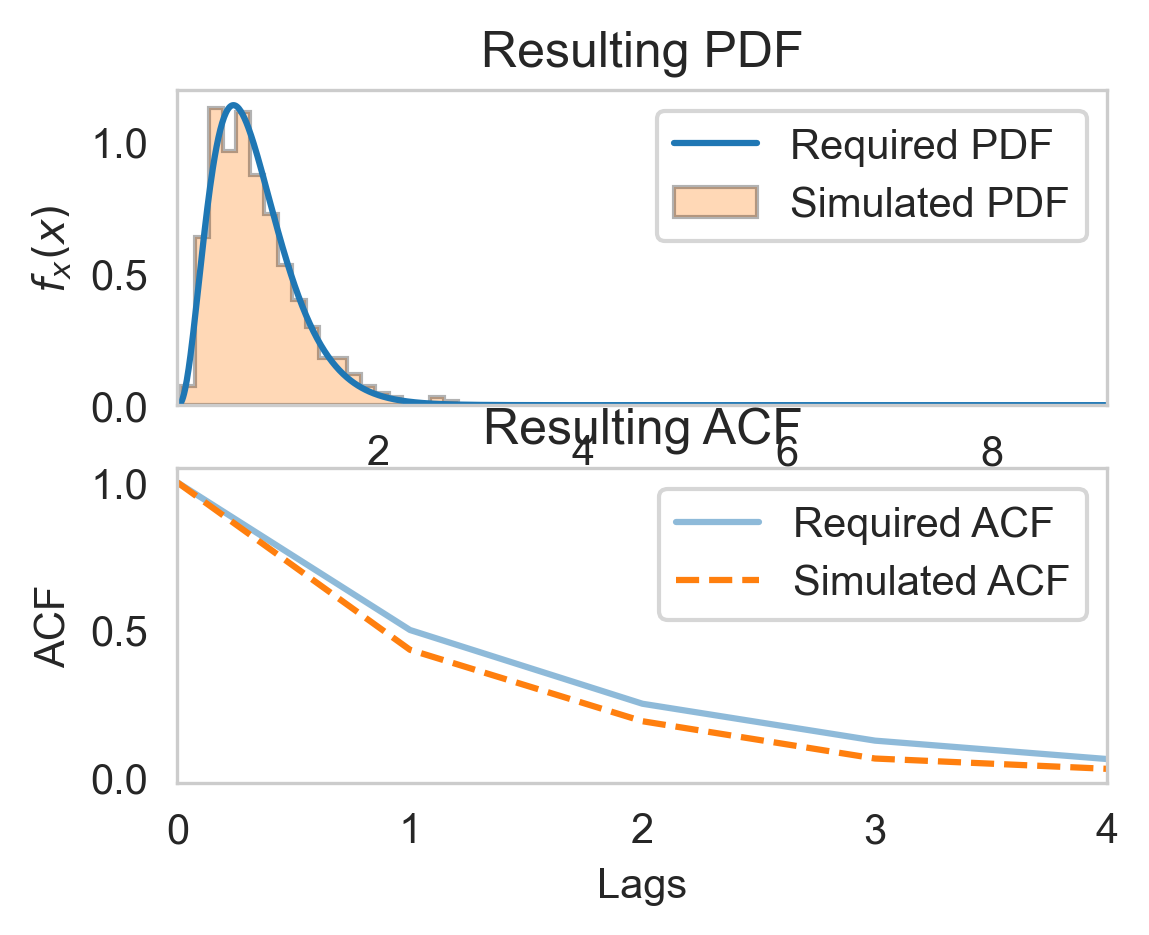

[0.73861339 0.60808288 1.00733048 1.62560599 0.6703815  0.22949998
 0.26713132 0.26643198 0.26646767 0.39801815 1.47027984 1.28317061
 0.6394829  0.23775561 0.33997    0.69462167 0.76439186 1.31033954
 1.04906887 1.14565311 0.9917673  0.96128685 1.65357151 1.11100506
 0.91303231 0.68246861 0.84981327 1.15937389 0.96697736 0.53641477
 0.70758833 1.53938736 1.17630106 1.62820362 0.94594534 0.58077883
 1.14797492 0.39153037 0.37854308 0.46917764 0.30244747 0.65138076
 1.46689442 1.66597907 1.37215979 1.05235732 0.72995441 1.10099996
 1.09807292 1.55344725 1.19905743 1.92615532 0.46177291 0.94282317
 1.57238395 0.80224851 0.65492202 0.37044526 0.25918892 0.59646932
 0.83285937 0.74971003 0.48894562 0.79506157 0.61164072 1.29929761
 0.84268768 0.42183721 0.69913118 0.30932085 0.30221707 0.81312515
 1.00042732 0.919732   0.64300116 0.5364017  1.59803671 1.14185909
 1.44255912 1.32368107 0.91109488 0.32349688 0.409701   0.38279865
 0.83038226 0.97962768 0.52764628 0.44898339 1.07367636 1.6257

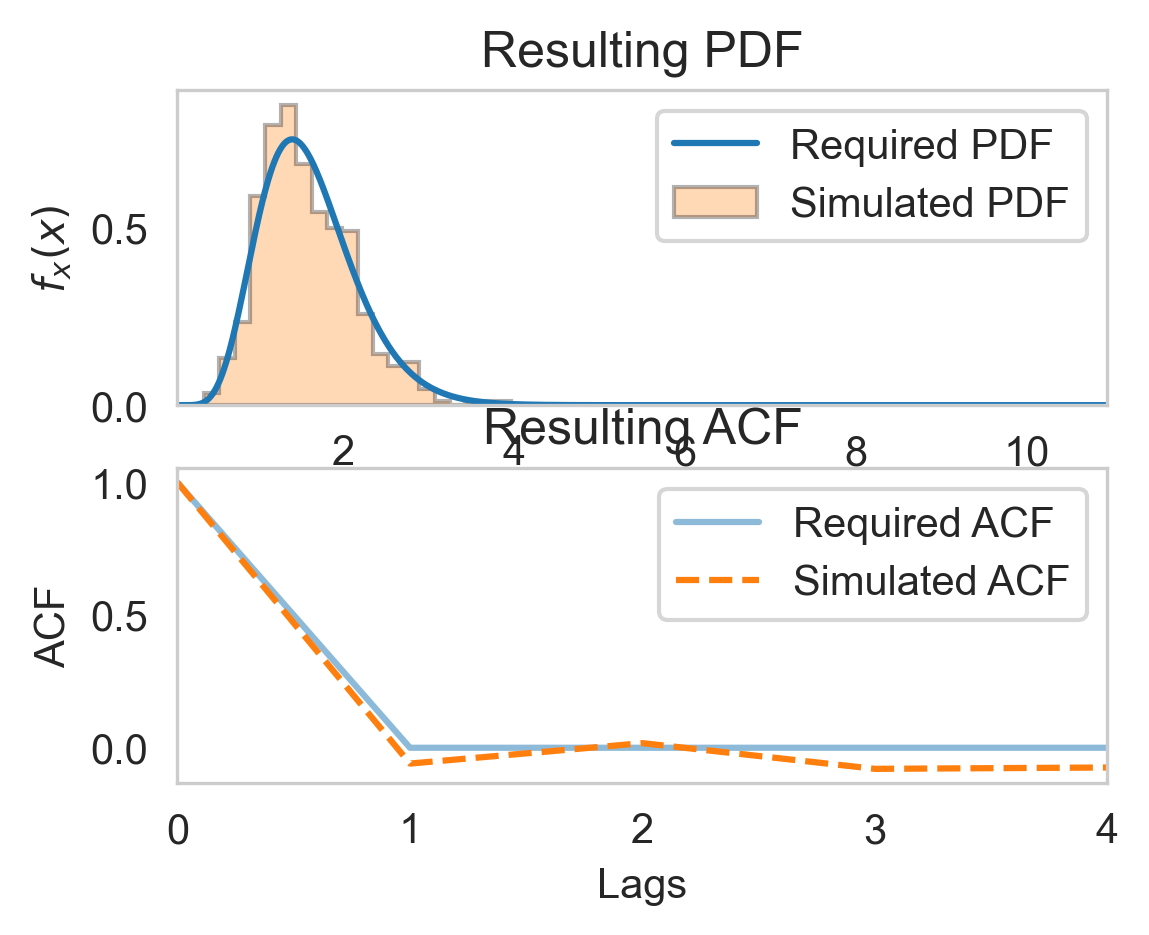

[1.62723965 1.78705358 1.86168719 1.28071112 1.56620675 1.44175345
 1.28723752 1.08140073 1.5927602  1.68707813 1.02518878 2.00394345
 2.92890686 1.26083269 1.49058161 0.76124027 0.78999128 2.84654143
 1.68178532 1.5890654  1.32713926 1.53409545 2.2461317  1.86530272
 2.52008909 1.84570578 2.14518238 2.01410678 1.26124377 0.78632097
 1.227861   1.19833635 1.05279941 1.99732577 1.95523392 1.46375065
 1.4578684  0.92415594 1.58090925 1.07898992 2.58989633 1.29566618
 1.33886182 2.17719295 1.3271632  1.21764705 2.14336352 1.65206661
 2.86995359 1.21029106 1.11838033 1.87090833 1.88788716 1.24770681
 2.39770073 1.12314649 1.99557955 1.63306248 1.54383033 0.55025999
 3.70025477 1.33527442 2.72084497 2.86702402 1.8121324  1.43388354
 1.77580324 1.451623   1.39913431 1.64975736 1.24055713 1.26184393
 1.2593846  1.30655519 2.10398735 1.1985454  1.24378526 2.07971905
 1.71998458 1.84652821 2.07469341 1.91218055 1.13607562 1.99307231
 1.56536568 1.88246321 1.52944847 1.43942763 1.78796586 1.5654

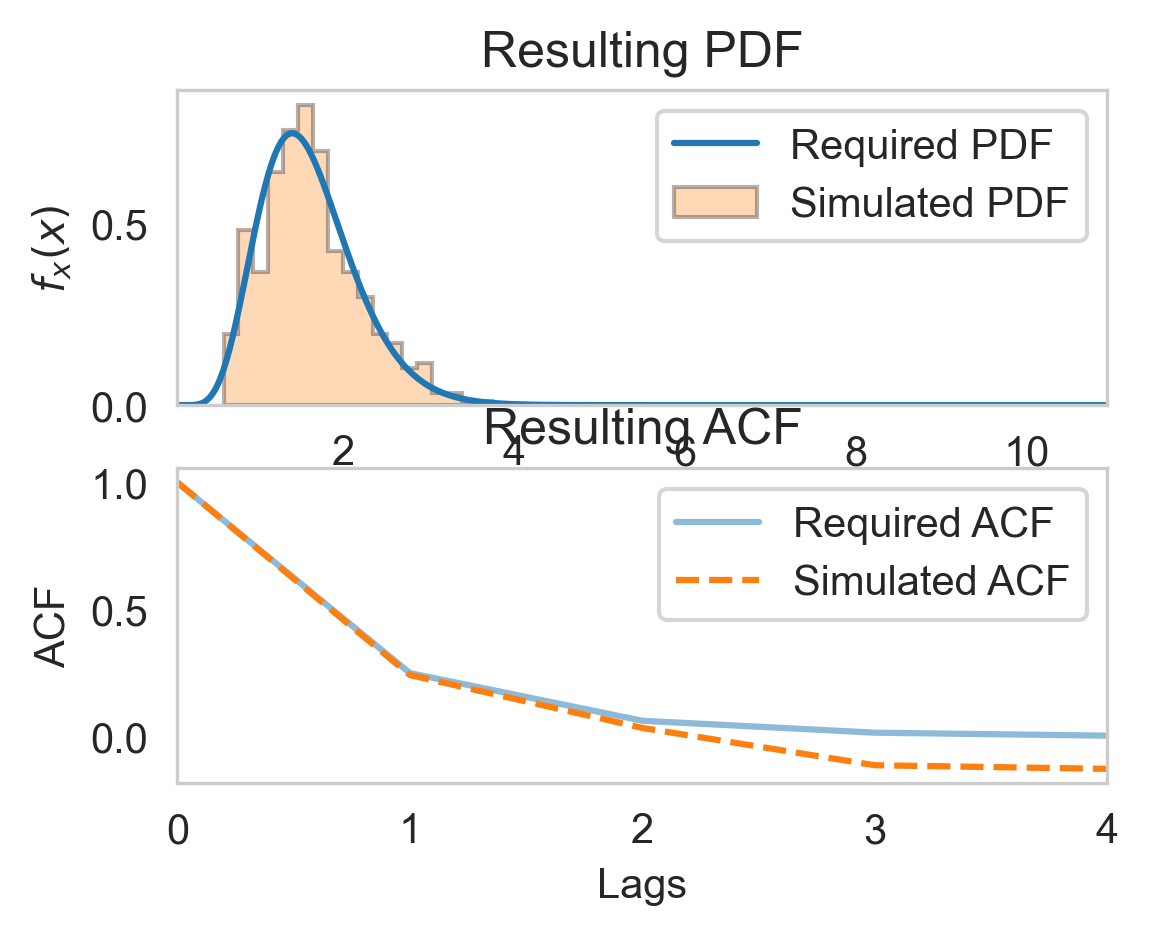

[1.36358656 2.15070494 1.35333956 1.07774012 1.57346989 1.72473605
 3.30711778 1.14495003 1.69374643 1.89253021 1.9624535  2.28752506
 1.98108774 1.80388829 1.53582089 1.58984905 1.58520215 1.20670453
 2.2366813  1.59043723 1.78310346 1.0500075  1.33838473 1.30928003
 1.55729118 2.0443926  1.74607957 1.46722374 1.48697459 1.9331477
 1.04767577 1.24537211 1.08556246 0.92839947 1.32982797 2.17641642
 2.03064283 1.74874638 1.30622606 1.60929429 1.07177815 1.52337909
 1.45645753 1.68906558 1.78524029 0.94864567 2.26881479 1.32209718
 0.93364027 1.52745747 1.65268752 2.45451087 1.1676575  2.93885739
 1.46986291 1.35759954 1.75714669 1.86314973 2.1075193  2.44214714
 1.54204974 0.79032263 0.67749133 1.07510073 1.43991796 1.06357516
 1.77242531 1.71877589 1.7608188  1.66776911 1.86075143 1.99174415
 1.30749389 0.88417948 1.23326856 1.4995104  2.55333214 2.13800473
 0.83461046 1.6277972  2.04386479 1.0200746  1.82163686 2.22051229
 3.73368196 2.95583079 1.62809039 1.4882106  1.32438553 1.48785

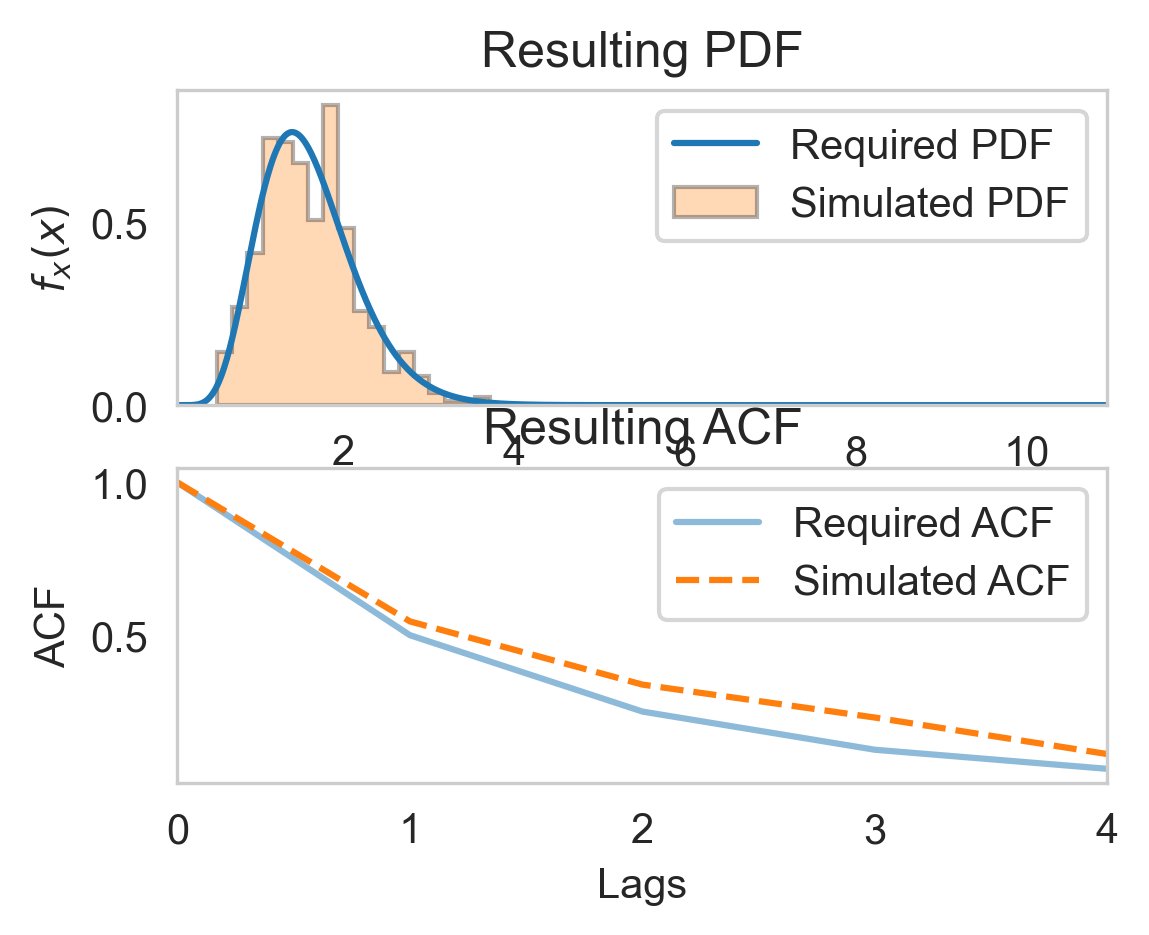

[1.56883914 0.58535844 1.3212049  1.69217632 1.10018133 2.02047999
 1.3173779  1.91841569 1.77518262 1.30299325 1.50671677 0.99057656
 1.79615577 1.25048038 0.70136955 1.57257924 2.21595476 2.56537969
 3.05562804 2.56591582 1.7796487  1.56656453 1.35313272 1.63392879
 1.97255211 2.03294333 2.48682678 2.36135949 1.73322357 1.72252734
 1.74140345 1.64084732 1.6941896  1.32227658 1.56224999 0.93102485
 1.15073043 0.9620203  1.32216377 1.92398991 1.15159748 2.04786973
 1.19648975 1.07678578 2.02988967 1.6409783  1.80109768 2.7178736
 2.48895747 2.75226346 2.83082497 1.80930244 1.93178953 1.99064384
 1.25488973 1.87589695 1.88817627 0.80572143 1.54547178 1.30983016
 0.78118773 1.05396106 1.33287781 1.46528928 0.56360626 1.09473738
 0.76961965 0.70912434 0.55063162 1.05262694 1.48835181 2.39859204
 0.89504483 1.24994529 0.96468168 1.05501662 1.1151024  1.24601313
 0.93036295 1.49158959 1.51953407 1.14991912 2.61814201 1.70988898
 2.08775633 2.26568766 2.46218598 1.80746222 1.4564276  1.34042

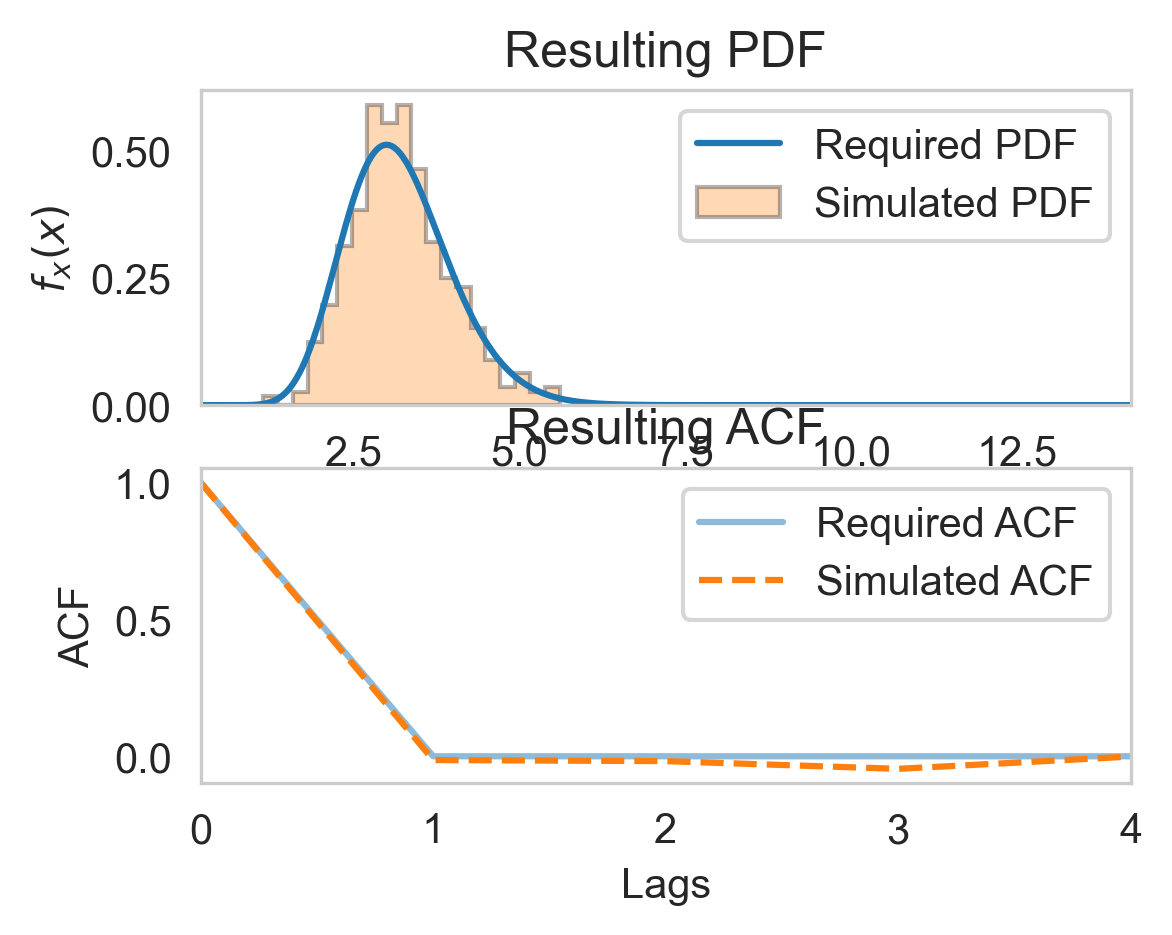

[3.12054238 3.08833326 3.15796447 2.54096219 3.27064954 2.68082077
 3.36254496 3.61229309 3.63408794 1.7499321  2.64643385 3.17167851
 4.20431317 2.46147362 2.75198056 3.63739639 2.39768321 2.34026468
 5.09495915 2.17108733 3.48822951 4.22378036 2.60362924 3.38968044
 2.82429744 3.50599049 3.71790056 1.66030607 5.03015005 2.5202004
 2.37298756 2.84815713 3.75015083 2.32693843 4.98370562 2.61618891
 2.1779857  2.11710001 4.89563343 3.86279532 2.46145993 2.06948344
 4.68403888 3.33672857 2.80792545 2.15348622 3.34674488 2.7868446
 2.64963351 2.80251594 3.32259076 3.03642546 2.81900752 3.07074453
 2.8143161  3.71748032 3.25498344 2.45392683 2.72928434 2.22563594
 3.34913288 3.49524672 4.0201755  2.49981057 3.1297832  3.31377429
 2.3498942  4.03148599 3.34456362 1.7360823  2.95473425 3.10082438
 4.28518678 5.60666323 3.76213974 4.62527871 3.67902995 1.99995937
 3.23944172 4.5925844  3.47550384 2.95289412 2.35829164 3.58662111
 3.3621784  3.8422362  3.19574711 4.97380589 3.03621829 2.532885

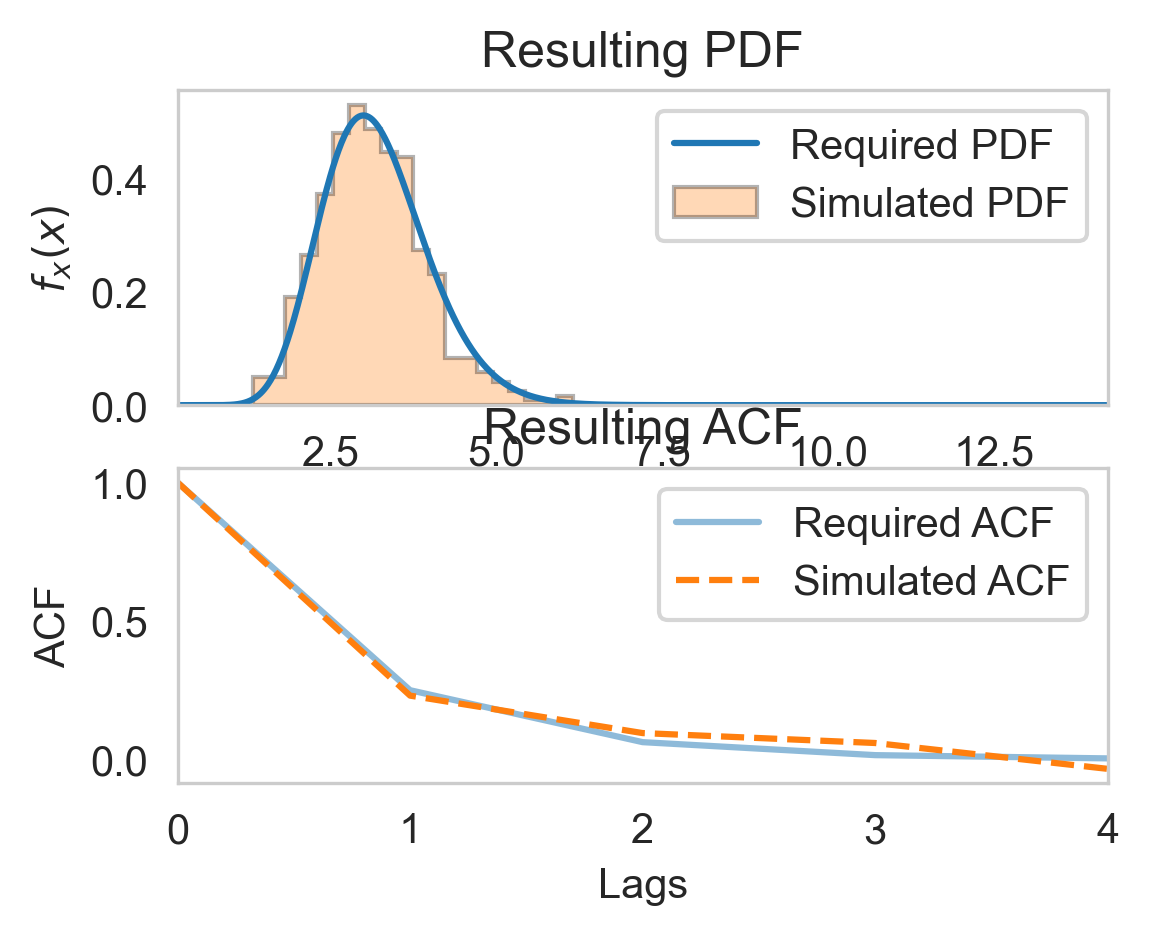

[2.52250526 2.10505474 2.82306115 3.3357634  4.04974444 4.73116602
 3.17309085 3.63665451 5.9077332  3.60645862 3.59167924 6.15321207
 4.99735158 3.09893936 3.68922518 4.16470283 3.16096466 4.15667224
 4.65280159 1.75559594 2.41582637 1.93683346 2.58409836 4.04000511
 3.81946319 3.17917202 2.12275291 3.80481249 2.87794684 3.83867767
 4.0929125  2.88544727 2.73327255 2.28265776 2.2349945  2.52893828
 2.8535709  3.53011543 4.89939329 4.42165762 2.92262714 1.73901187
 2.25773898 2.52146867 2.9423424  4.03611096 3.61049997 3.51657024
 4.49289933 2.93887977 4.95607541 2.80937684 3.52585476 3.31116151
 2.44915472 2.25137927 2.07880781 2.3867903  3.37385152 3.83315565
 3.58885135 2.26518264 3.19285845 3.00689117 2.97223553 3.91462344
 4.04854919 3.5108325  2.89041128 3.33147447 2.93099883 2.51533226
 2.48793465 2.7377323  1.92728329 1.94680428 1.92393041 2.07507579
 3.88484132 3.42401391 3.70844784 1.88919028 3.39584215 2.4887246
 3.093844   2.8533216  2.388754   2.26848151 2.50854465 3.07521

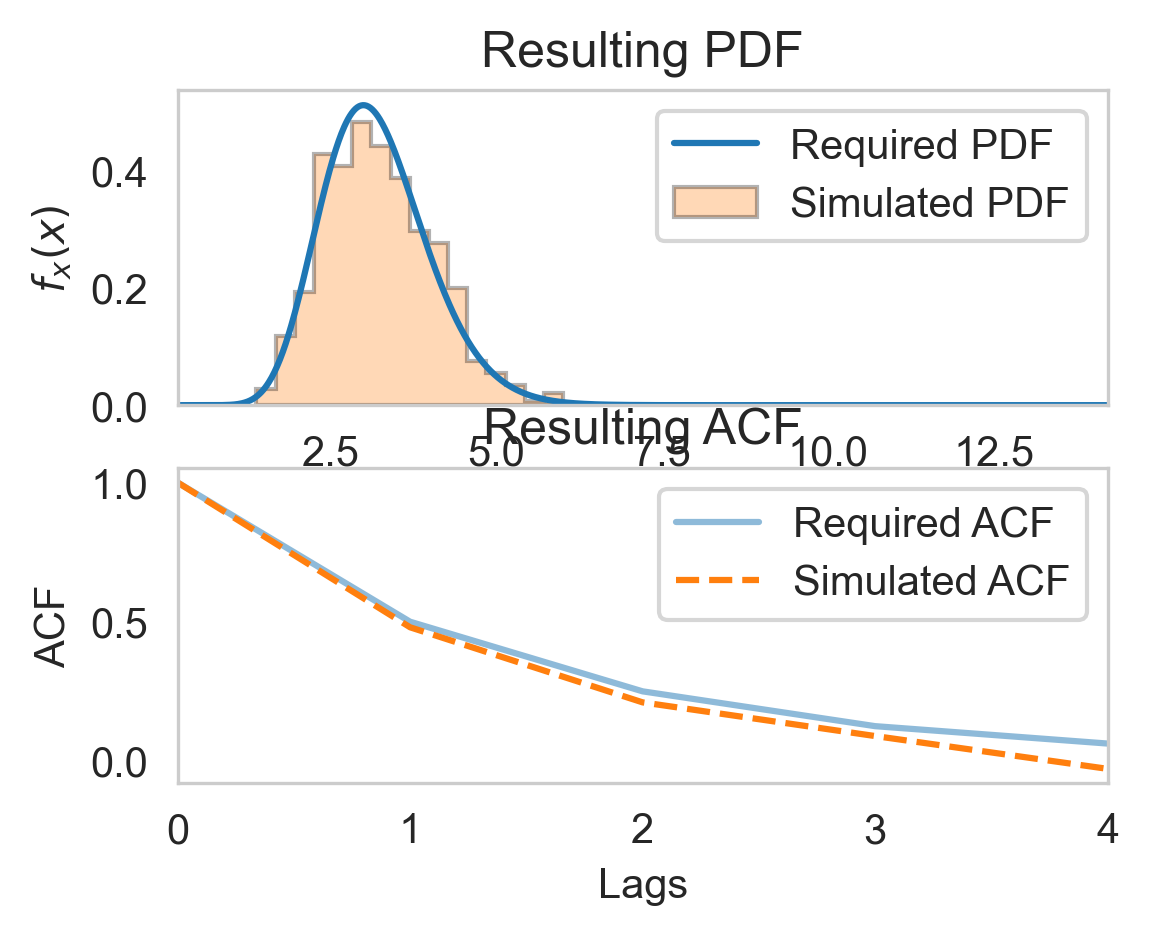

[3.2553287  4.19312846 3.43490595 3.49545723 5.15968866 3.96282048
 4.13206168 4.49390486 3.19618076 2.95735219 3.13888802 3.60584884
 2.99955754 2.66558041 2.958544   2.05792956 2.29840666 3.52901016
 3.89186997 3.08761624 2.55152596 3.27762017 4.03586533 3.16526247
 3.69017926 4.38658816 4.34346436 3.63948659 2.76115389 1.68105382
 3.12926795 3.25547642 3.96208238 4.22381576 3.701907   2.99307487
 3.37181715 5.09945445 5.45871926 4.37258961 3.85912478 2.96165423
 4.51018402 2.99974357 3.37855666 2.76994312 3.71190115 4.47526183
 3.45390558 2.88485122 3.45164739 3.22451067 3.8725116  3.76995609
 2.90134403 2.62661552 4.16833812 4.08472266 2.52810977 4.09286862
 4.19360817 3.63963731 1.89439322 2.25114475 3.02753427 1.91854751
 1.95031215 2.21368463 2.75081008 3.35142722 3.18348317 3.24094844
 2.70526997 2.87096475 2.27066893 1.78968887 2.53983422 2.37058135
 2.46938209 1.82354589 2.90791452 3.37960215 3.81573145 4.7131167
 4.57192627 3.23407013 4.87725795 4.56204746 3.64971769 3.84833

In [51]:
from itertools import product as it_prod

acf_50 = 1 / (2 ** np.arange(5))  # 0.5 corr
acf_25 = 1 / (4 ** np.arange(5))
acf_12 = 1 / (8 ** np.arange(5))
acf_00 = np.zeros(5)
acf_00[0] = 1.0

target_mean_var_s = (
    (2*0.050, 2*0.010),
    (2*0.100, 2*0.020),
    (2*0.200, 2*0.040),
    (2*0.400, 2*0.080),
    (2*0.800, 2*0.160),
    (2*1.600, 2*0.320),
)
loc = 0.042

for (mean, var), (acf, acf_name) in it_prod(target_mean_var_s, ((acf_00, "acf00"), (acf_25, "acf25"), (acf_50, "acf50"))):    
    dist, _, _ = gamma_with_params(loc, mean, var)
    print(f"Mean {mean:0.02f} Var {var:0.02f} ACF {acf_name}")
    seq = gen_corr_sequence(
        dist_obj=dist,
        L=500,
        target_acf=acf,
        debug=True,
    )
    print(seq)
